In [1]:
import numpy as np
import sys, os

!pip install -U tensorly
!pip install opencv-python
import matplotlib.pyplot as plt
import tensorly as tl
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import os
import cv2
from skimage.metrics import structural_similarity as ssim
from mpl_toolkits.mplot3d import axes3d
from scipy.misc import face
from scipy.ndimage import zoom
from tensorly.decomposition import parafac
from tensorly.decomposition import tucker
from math import ceil


np.random.seed(42)

Requirement already up-to-date: tensorly in ./anaconda3/lib/python3.7/site-packages (0.4.5)


In [2]:
seed = 42
sourcepath = "/media/data1/hsm/FACE_FORENSICS_C40/New_Preproc/"
real_data_dir = os.path.join(sourcepath, 'REAL')
fake_data_dir = os.path.join(sourcepath, 'FAKE', 'NeuralTextures')

real_filenames = np.array([os.path.join('REAL', f) for f in os.listdir(real_data_dir)])
fake_filenames = np.array([os.path.join('FAKE', 'NeuralTextures', f) for f in os.listdir(fake_data_dir)])

print("FROM DIR")
print("REAL: ", len(real_filenames))
print("FAKE: ", len(fake_filenames))
print("TOTAL: ", len(real_filenames) + len(fake_filenames))

FROM DIR
REAL:  119636
FAKE:  71302
TOTAL:  190938


In [3]:
# random sampling
TOTAL_DATA_SIZE = 20000
real_filenames = np.random.choice(real_filenames, TOTAL_DATA_SIZE//2, replace = False).tolist()
fake_filenames = np.random.choice(fake_filenames, TOTAL_DATA_SIZE//2, replace = False).tolist()

In [4]:
class ImageCreator():
    def __init__(self, sourcepath, savepath, real_filenames, fake_filenames):
        self.sourcepath = sourcepath
        self.savepath = savepath
        self.real_filenames = real_filenames
        self.fake_filenames = fake_filenames
        self.to_or = lambda x: x
        self.to_tk = lambda x: self.to_image(self.to_TK(self.to_tensor(x))) # to tk image
        self.to_cp = lambda x: self.to_image(self.to_CP(self.to_tensor(x))) # to cp image
        self.to_tk_diff = lambda x: self.to_image(self.get_diff_image(self.to_image(self.to_TK(self.to_tensor(x))), x))
        self.to_cp_diff = lambda x: self.to_image(self.get_diff_image(self.to_image(self.to_CP(self.to_tensor(x))), x))
        
    def create_image(self, subpath, preprocessing, real_path = "REAL", fake_path = "FAKE/NeuralTextures"):
        # get files here
        savepath = os.path.join(self.savepath, subpath)
        print("== Saving Data at {} ==".format(savepath))
        
        # assertions
        root_exists = os.path.exists(savepath)
        r = os.path.join(savepath, real_path)
        r_exists = os.path.exists(r)
        f = os.path.join(savepath, fake_path)
        f_exists = os.path.exists(f)
        
        print(savepath, ":", root_exists)
        print(r, ":", r_exists)
        print(f, ":", f_exists)
        assert(root_exists and r_exists and f_exists)
        
        r_hasfile = len(os.listdir(r))
        f_hasfile = len(os.listdir(f))        
        print("file count in real: ", r_hasfile)
        print("file count in fake: ", f_hasfile)

        assert(not(r_hasfile or f_hasfile))
        print("== assertion done ==")

        # Create real files
        print("CREATING REAL FILES")
        cnt = 0
        total = len(self.real_filenames)
        for p in self.real_filenames:
            file = os.path.join(self.sourcepath, p)
            image = cv2.imread(file)
            created_image = preprocessing(image)
            filename = os.path.join(savepath, p)
            cv2.imwrite(filename, created_image)
            if(cnt == 0):
                print(filename)
                plt.imshow(created_image)
                plt.show()
            print(".", end = "")
            cnt += 1
            if cnt % 100 == 0 :
                print("({}/{})".format(cnt, total))
        print("REAL FILE DONE")
        
        # Create fake files
        cnt = 0
        total = len(self.fake_filenames)
        for p in self.fake_filenames:
            file = os.path.join(self.sourcepath, p)
            image = cv2.imread(file)
            created_image = preprocessing(image)
            filename = os.path.join(savepath, p)
            cv2.imwrite(filename, created_image)
            if(cnt == 0):
                print(filename)
                plt.imshow(created_image)
                plt.show()
            print(".", end = "")
            cnt += 1
            if cnt % 100 == 0 :
                print("({}/{})".format(cnt, total))
        print("FAKE FILE DONE")
        
    def show_image(self, curpath, subpath, real_path = "REAL", fake_path = "FAKE/NeuralTextures", index = 0):
        # location
        real_loc = os.path.join(curpath, subpath, real_path)
        fake_loc = os.path.join(curpath, subpath, fake_path)
        
        real_filenames = np.array([os.path.join(real_path, f) for f in os.listdir(real_loc)])
        fake_filenames = np.array([os.path.join(fake_path, f) for f in os.listdir(fake_loc)])
        
        # file name
        real_file = os.path.join(curpath, subpath, real_filenames[index])
        fake_file = os.path.join(curpath, subpath, fake_filenames[index])

        # image
        real_image = cv2.cvtColor(cv2.imread(real_file), cv2.COLOR_BGR2RGB)
        fake_image = cv2.cvtColor(cv2.imread(fake_file), cv2.COLOR_BGR2RGB)
        
        # show
        fig = plt.figure()
        rows = 1
        cols = 2
        ax1 = fig.add_subplot(rows, cols, 1)
        ax1.imshow(real_image)
        ax1.set_title('REAL')
        ax1.axis("off")

        ax2 = fig.add_subplot(rows, cols, 2)
        ax2.imshow(fake_image)
        ax2.set_title('FAKE')
        ax2.axis("off")

        plt.show()

    # original image to tensor  
    def to_tensor(self, image):
        return tl.tensor(zoom(image, (1, 1, 1)), dtype='float64')

    # tensor to image
    def to_image(self, tensor):
        im = tl.to_numpy(tensor)
        im -= im.min()
        im /= im.max()
        im *= 255
        return im.astype(np.uint8)

    # get image difference
    def get_diff_image(self, image1, image2):
        output = lambda x: (x - np.min(x)) / np.max(x) # normalize
        x = np.abs(image1.astype(np.int)-image2.astype(np.int))
        return output(x)

    # tensor decomposition using CP 
    def to_CP(self, tensor, r = 8):
        # Rank of the CP decomposition
        cp_rank = r
        # Perform the CP decomposition
        weights, factors = parafac(tensor, rank=cp_rank, init='random', tol=10e-6)
        # Reconstruct the image from the factors
        cp_reconstruction = tl.kruskal_to_tensor((weights, factors)) 
        return cp_reconstruction
    
    # tensor decomposition using TK
    def to_TK(self, tensor, r = [30, 30, 3]):
        # Rank of the Tucker decomposition
        tucker_rank = r
        random_state = 42
        # Tucker decomposition
        core, tucker_factors = tucker(tensor, ranks=tucker_rank, init='random', tol=10e-5, random_state=random_state)
        tucker_reconstruction = tl.tucker_to_tensor((core, tucker_factors))
        return tucker_reconstruction

In [5]:
os.getcwd()

'/home/dongmin'

In [6]:
imcr = ImageCreator(sourcepath, os.getcwd(), real_filenames, fake_filenames)

In [7]:
imcr.create_image('OR', imcr.to_or)

== Saving Data at /home/dongmin/OR ==
/home/dongmin/OR : True
/home/dongmin/OR/REAL : True
/home/dongmin/OR/FAKE/NeuralTextures : True
file count in real:  10000
file count in fake:  10000


AssertionError: 

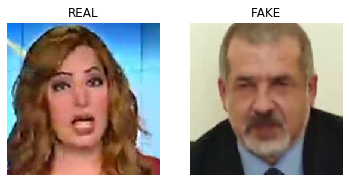

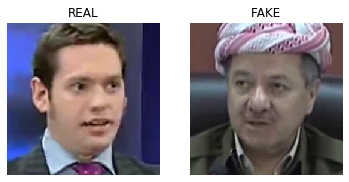

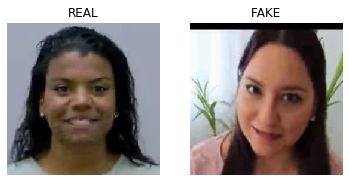

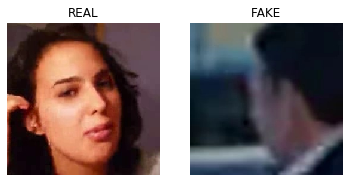

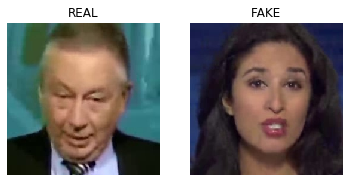

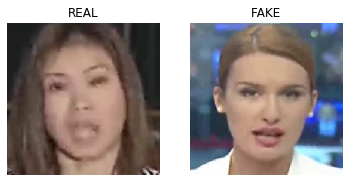

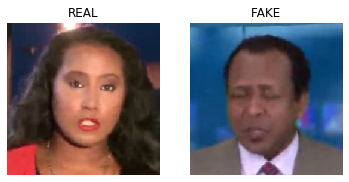

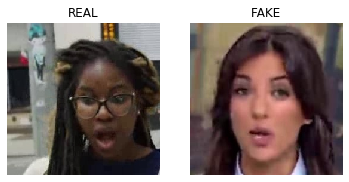

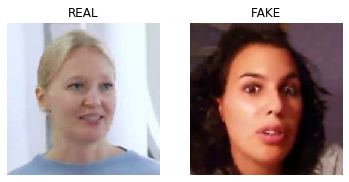

In [8]:
for i in range(9):
    imcr.show_image(os.getcwd(), 'OR', index = i)

== Saving Data at /home/dongmin/TK ==
/home/dongmin/TK : True
/home/dongmin/TK/REAL : True
/home/dongmin/TK/FAKE/NeuralTextures : True
file count in real:  0
file count in fake:  0
== assertion done ==
CREATING REAL FILES
/home/dongmin/TK/REAL/20__walking_down_street_outside_angry_frame115.jpg


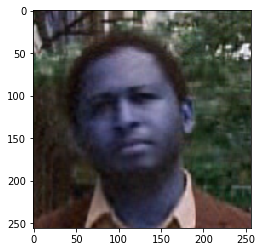

....................................................................................................(100/10000)
....................................................................................................(200/10000)
....................................................................................................(300/10000)
....................................................................................................(400/10000)
....................................................................................................(500/10000)
....................................................................................................(600/10000)
....................................................................................................(700/10000)
....................................................................................................(800/10000)
....................................................................................................(900

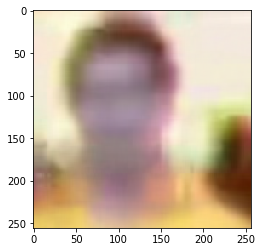

....................................................................................................(100/10000)
....................................................................................................(200/10000)
....................................................................................................(300/10000)
....................................................................................................(400/10000)
....................................................................................................(500/10000)
....................................................................................................(600/10000)
....................................................................................................(700/10000)
....................................................................................................(800/10000)
....................................................................................................(900

In [9]:
imcr.create_image('TK', imcr.to_tk)

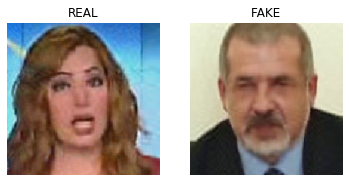

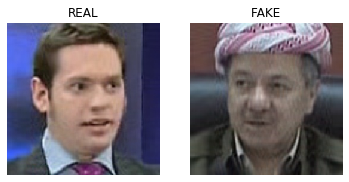

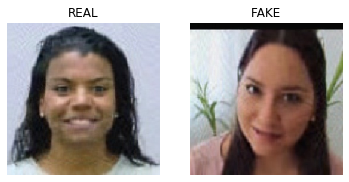

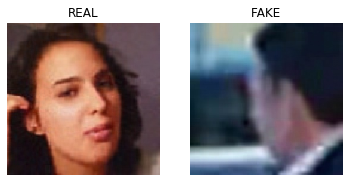

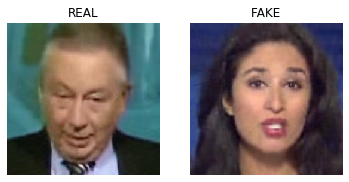

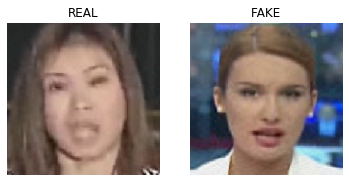

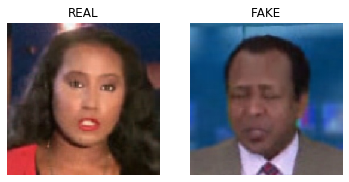

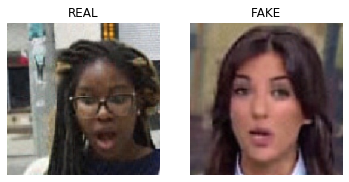

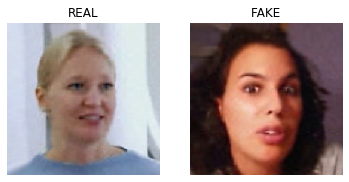

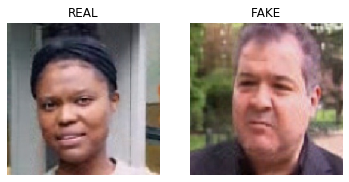

In [10]:
for i in range(10):
    imcr.show_image(os.getcwd(), 'TK', index = i)

== Saving Data at /home/dongmin/TK_diff ==
/home/dongmin/TK_diff : True
/home/dongmin/TK_diff/REAL : True
/home/dongmin/TK_diff/FAKE/NeuralTextures : True
file count in real:  0
file count in fake:  0
== assertion done ==
CREATING REAL FILES
/home/dongmin/TK_diff/REAL/20__walking_down_street_outside_angry_frame115.jpg


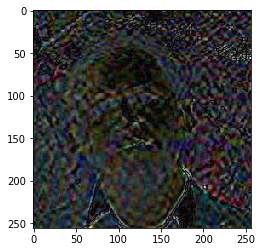

....................................................................................................(100/10000)
....................................................................................................(200/10000)
....................................................................................................(300/10000)
....................................................................................................(400/10000)
....................................................................................................(500/10000)
....................................................................................................(600/10000)
....................................................................................................(700/10000)
....................................................................................................(800/10000)
....................................................................................................(900

....................................................................................................(7300/10000)
....................................................................................................(7400/10000)
....................................................................................................(7500/10000)
....................................................................................................(7600/10000)
....................................................................................................(7700/10000)
....................................................................................................(7800/10000)
....................................................................................................(7900/10000)
....................................................................................................(8000/10000)
................................................................................................

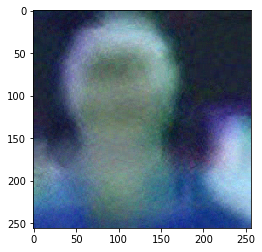

....................................................................................................(100/10000)
....................................................................................................(200/10000)
....................................................................................................(300/10000)
....................................................................................................(400/10000)
....................................................................................................(500/10000)
....................................................................................................(600/10000)
....................................................................................................(700/10000)
....................................................................................................(800/10000)
....................................................................................................(900

....................................................................................................(7300/10000)
....................................................................................................(7400/10000)
....................................................................................................(7500/10000)
....................................................................................................(7600/10000)
....................................................................................................(7700/10000)
....................................................................................................(7800/10000)
....................................................................................................(7900/10000)
....................................................................................................(8000/10000)
................................................................................................

In [8]:
imcr.create_image('TK_diff', imcr.to_tk_diff)

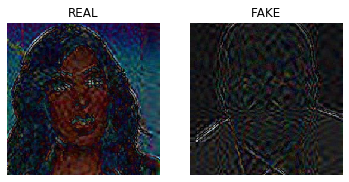

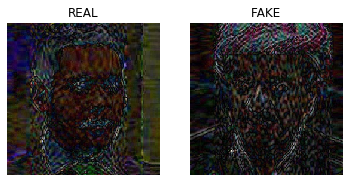

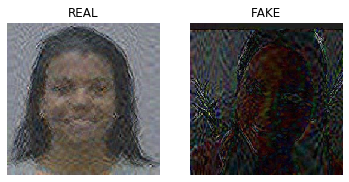

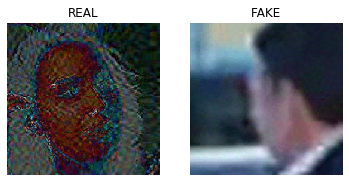

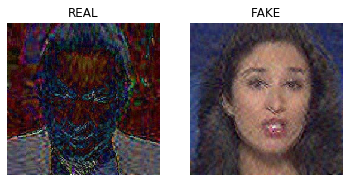

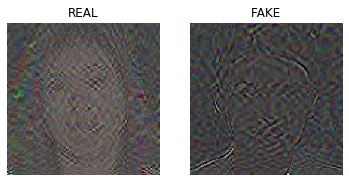

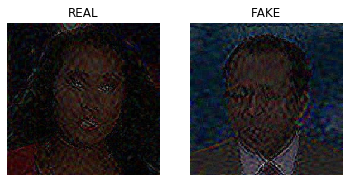

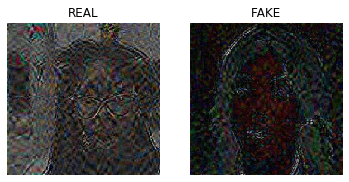

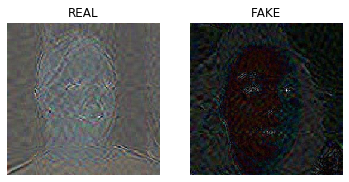

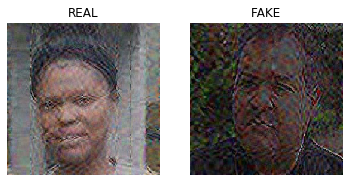

In [9]:
for i in range(10):
    imcr.show_image(os.getcwd(), 'TK_diff', index = i)